In [2]:
from pytorch_msssim import ssim
import os
import numpy as np
import matplotlib.pyplot as plt
from mri_dataset import MRIDataset
from pytorch_resnet import PytorchResNet3D
from torch.utils.data import DataLoader
import torch

def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, phys_size, x=None, y=None, z=None, window=None, level=None, existing_ax=None):
    width, height, depth = phys_size
    
    size = np.flip(img.shape)
    spacing = phys_size / size

    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)

    if window is None:
        window = np.max(img) - np.min(img)

    if level is None:
        level = window / 2 + np.min(img)

    low,high = wl_to_lh(window,level)

    if existing_ax is None:
        # Display the orthogonal slices
        fig, axes = plt.subplots(1, 3, figsize=(14, 8))
    else:
        axes = existing_ax

    axes[0].imshow(img[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    axes[1].imshow(img[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    axes[2].imshow(img[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    axes[0].axhline(y * spacing[1], lw=1)
    axes[0].axvline(x * spacing[0], lw=1)

    axes[1].axhline(z * spacing[2], lw=1)
    axes[1].axvline(x * spacing[0], lw=1)

    axes[2].axhline(z * spacing[2], lw=1)
    axes[2].axvline(y * spacing[1], lw=1)

    if existing_ax is None:
        plt.show()

In [3]:
localised_box_size = np.array([80, 80, 112])
generalised_box_size = np.array([0.289, 0.307483, 0.4804149]) * 200

base = '/vol/bitbucket/mb4617'
data_path = f'{base}/MRI_Crohns/numpy_datasets'
suffix = 'all_data'
input_size = [87, 87, 87]

all_modalities = True
localisation = False
fold = 0

input_features = [1, 1, 1] if all_modalities else [1, 0, 0]
folder = 'ti_imb' if localisation else 'ti_imb_generic'

dataset_paths = [f'{data_path}/{folder}/{suffix}_train_fold{fold}.npz']#, f'{data_path}/{folder}/{suffix}_test_fold{fold}.npz']

dsets = [MRIDataset(p, False, input_size, input_features) for p in dataset_paths]

all_data = torch.cat([ torch.stack([d for d,_ in dset.data], axis=0) for dset in dsets])

data_range = torch.max(all_data)


['axial_t2', 'coronal_t2', 'axial_pc']


160.07193 ,  103.75145
0.0 - 1716.0


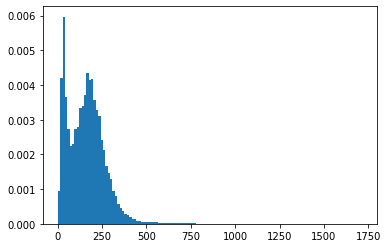

150.76791 ,  93.501495
0.0 - 1405.0


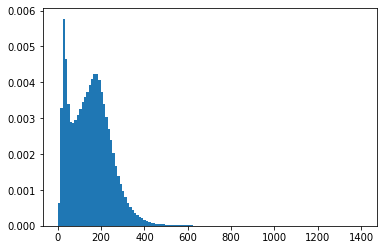

125.02162 ,  83.88862
0.0 - 1273.0


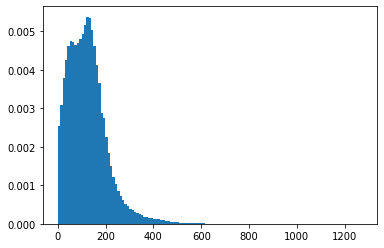

In [4]:
def show_dist(dset):
    for chan in range(3):
        curr_chan_data = dset[:,chan].numpy().flatten()
        print(np.mean(curr_chan_data),', ',np.std(curr_chan_data))
        print(np.min(curr_chan_data), '-', np.max(curr_chan_data))
        plt.hist(curr_chan_data, bins=128, density=True)
        plt.show()

160.07195 ,  103.75146
-0.020731546 - 1716.004


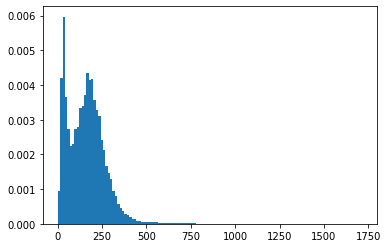

150.76794 ,  93.501495
-0.021912238 - 1405.01


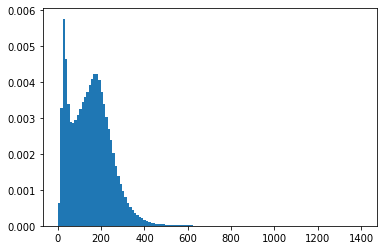

125.02161 ,  83.888626
-0.023645278 - 1272.9968


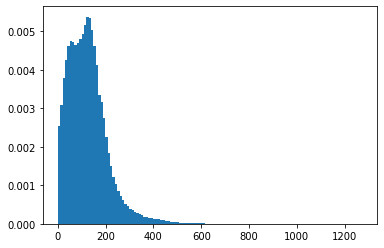

tensor(1.)


In [7]:
tiny_noise = all_data + 0.005 * torch.randn_like(all_data)

show_dist(tiny_noise)

print(ssim(all_data, tiny_noise, data_range=data_range))

160.07257 ,  103.8723
-22.92147 - 1720.9641


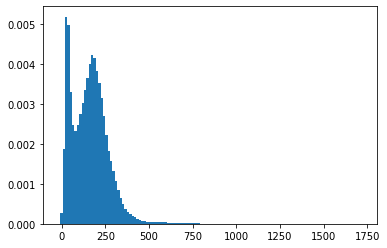

150.7682 ,  93.63468
-21.811104 - 1409.6068


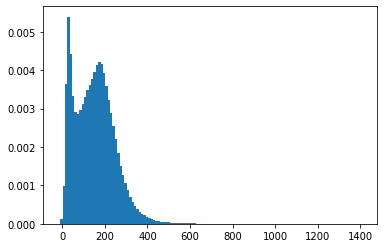

125.0218 ,  84.03762
-22.960176 - 1276.3293


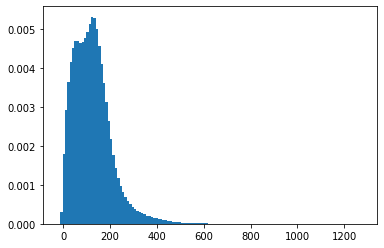

<function ssim at 0x7fbb4b0f7310>


In [8]:
medium_noise = all_data + 5 * torch.randn_like(all_data)

show_dist(medium_noise)

medium_ssim = ssim(all_data, medium_noise, data_range=data_range)

print(medium_ssim)

In [9]:
medium_ssim

tensor(0.9942)

In [8]:
ssims = []

noise = torch.randn_like(all_data)
for sig in [7, 8]:
    new_ssim = ssim(all_data, all_data + sig * noise, data_range=data_range)
    print(f'sigma {sig} - ssim {new_ssim}')
    ssims.append(new_ssim)

# sigma  5 - ssim 0.9942
# sigma  7 - ssim 0.9887310266494751
# sigma  8 - ssim 0.9853401184082031
# sigma 10 - ssim 0.9773149490356445
# sigma 20 - ssim 0.9158517718315125
# sigma 40 - ssim 0.7375774383544922


sigma 7 - ssim 0.9887310266494751
sigma 8 - ssim 0.9853401184082031


In [ ]:
test_sample = all_data[0][0]
for std in [0, 5, 7, 8, 10]:
    display_image((test_sample + std * torch.randn_like(test_sample)).numpy(), generalised_box_size)